In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)

from data_loader import load_grid_search_data

# plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [2]:

def _vis_landscapes(
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None,
        converged_soln_markers=None,
    ):

    assert len(landscapes) == len(labels)
    assert len(landscapes) == len(params_paths)

    # plt.figure
    plt.rc('font', size=28)
    if len(landscapes) == 2:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    elif len(landscapes) == 3:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    elif len(landscapes) == 4:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))
    else:
        assert False

    fig.suptitle(title)
    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'])

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_title(labels[idx])
        axs[idx].set_xlabel('beta')
        axs[idx].set_ylabel('gamma')
        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, linewidth=3, color='purple', label="optimization path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial point")

            if isinstance(converged_soln_markers, list):
                marker = converged_soln_markers[idx]
                if marker == '*':
                    markersize = 15
                elif marker == 'D':
                    markersize = 10
                
            else:
                marker = '*'
                markersize = 15

            axs[idx].plot(xs[-1], ys[-1], marker=marker,
                    color='red', markersize=markersize, label="converged solution")

            axs[idx].legend()

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))])
    # plt.legend()
    fig.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close('all')


read grid search data from figs/grid_search/maxcut/sv-ideal-p=2/sv-ideal-n=16-p=2-seed=0-12-15.npz

recon landscape read from figs/grid_search_recon/maxcut/sv-ideal-p=2/recon-cs_seed=16-sf=0.050-sv-ideal-n=16-p=2-seed=0-12-15.npz
C_opt: -17.991035
offset: -12
eps: 0.4
[-5.88525391 -5.51513672 -5.54541016 -5.93408203 -5.99658203 -5.85546875
 -6.0546875  -5.38818359 -5.71630859 -5.65527344 -5.95068359 -6.01025391
 -6.        ]
[-5.53759766 -5.08935547 -5.31640625 -2.28369141 -5.5        -5.92041016
 -5.36621094 -5.79101562 -5.98486328 -5.89306641 -5.13085938 -5.99267578
 -5.43701172]
OSCAR mean: -5.326397235576923 RANDOM mean: -5.808255709134615
OSCAR mean: -4.868896484375 RANDOM mean: -5.766194661458333
{'bodies': [<matplotlib.collections.PolyCollection object at 0x29e1bd6d0>], 'cmaxes': <matplotlib.collections.LineCollection object at 0x29e1aa6d0>, 'cmins': <matplotlib.collections.LineCollection object at 0x29e1bdd60>, 'cbars': <matplotlib.collections.LineCollection object at 0x29e312

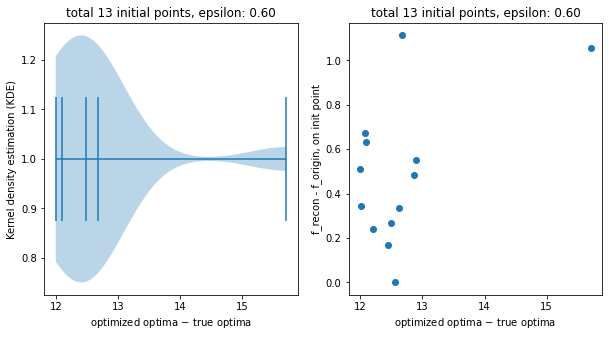

In [3]:

from data_loader import get_recon_landscape, get_recon_pathname


def vis_find_init_pts_by_recon(n_qubits: int, eps: float, noise: str):
    """n=20
    """
    n = n_qubits
    method = 'sv'
    problem = 'maxcut'
    cs_seed = n_qubits
    p = 2

    sf = 0.05
    seed = 0
    if p == 2:
        bs = 12
        gs = 15
    elif p == 1:
        bs = 50
        gs = 100
    else:
        raise ValueError("Invalid depth of QAOA")

    data, data_fname, _ = load_grid_search_data(
        n_qubits=n_qubits, p=p, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed
    )
    origin = data['data']

    recon_path, _, _ = get_recon_pathname(p, problem, method, noise, cs_seed, sf, data_fname)
    # recon1_path = f"figs/recon_p2_landscape/{timestamp}/recon-sf={sf:.3f}-cs_seed={cs_seed}-{miti1_data_fname}"
    recon = get_recon_landscape(p, origin, sf, False, recon_path, cs_seed)

    # recon_path = f"figs/gen_p1_landscape/sv-ideal/2D_CS_recon_p2/sf{sf:.3f}_bs{bs}_gs{gs}_nQ{n_qubits}_seed{seed}_csSeed{cs_seed}.npz"
    # recon = np.load(f"{recon_path}")['recon']

    # ====================== vis ======================
    # eps = 0.6
    if noise == 'ideal' and n == 16:
        init_data = np.load(
            "figs/find_init_pts_by_recon/2022-11-11_23:23:40/init-maxiter=None-eps=0.400-sv-ideal-n=16-p=2-seed=0-12-15.npz"
            # "figs/find_init_pts_by_recon/2022-11-05_22:03:07_OK/recon-eps=0.600-csSeed=16-sv-ideal-n=16-p=2-seed=0-12-15.npz"
            , allow_pickle=True)
        C_opt = -17.991035 # 当时忘记存了
        offset = -12
        
        
    elif noise == 'depolar-0.001-0.02' and n == 16:
        raise NotImplementedError("优化不动")

    elif noise == 'ideal' and n == 20:
        init_data_path = "figs/find_init_pts_by_recon/2022-11-11_14:13:36_OK/init-maxiter=None-eps=0.600-sv-ideal-n=20-p=2-seed=0-12-15.npz"
        print("init data path =", init_data_path)
        init_data = np.load(init_data_path, allow_pickle=True)
        offset = init_data['offset']
        C_opt = init_data['C_opt']
        
    elif noise == 'depolar-0.001-0.02' and n == 20:
        raise NotImplementedError("优化不动")
    
    ids = init_data['ids']
    energies = init_data['min_energies']
    min_recon = init_data['min_recon']
    initial_points = init_data['initial_points']
    recon_init_pt_vals = init_data['recon_init_pt_vals']
    # C_opt = init_data['C_opt']
    # offset = init_data['offset']
    # eps = init_data['eps']
    print("C_opt:", C_opt)
    print("offset:", offset)
    print("eps:", init_data['eps'])


    if n == 16:
        oscar_energies = init_data['min_energies'], # one to one correspondence to ids
        oscar_energies = oscar_energies[0]
        oscar_init = init_data['initial_points'], # one to one correspondence to ids
        oscar_rsts = init_data['oscar_rsts']

        random_rsts = init_data['random_rsts']
        random_inits = init_data['random_inits']
        random_energies = np.array([r[0] for r in random_rsts])

        ids_higher_bp = np.array(
            [1, 2, 3, 4, 9, 10]
        )
    
        print(random_energies)

        print(oscar_energies)

        print("OSCAR mean:", oscar_energies.mean(), "RANDOM mean:", random_energies.mean())
        print("OSCAR mean:", oscar_energies[ids_higher_bp].mean(), "RANDOM mean:", random_energies[ids_higher_bp].mean())

    # return

    # C_opt = -17.991035
    # offset = -12

    # energies = np.array(energies, dtype=float)
    # energies += offset

    # recon. error on the initial points
    recon_errors = []
    ids_needed = []
    for i in range(len(ids)): # idx: tuples
        # print(recon[idx[0], idx[1], idx[2], idx[3]])
        # print(recon[tuple(idx)])
        # print(idx, recon[idx[0], idx[1], idx[2], idx[3]])
        # continue

        init_recon = recon[tuple(ids[i])]
        init_origin = origin[tuple(ids[i])]
        
        if np.abs(min_recon - init_recon) >= eps:
            continue

        error = init_recon - init_origin
        # error = np.abs(init_recon - init_origin)
        error = np.abs(error)
        # print(init_origin, init_recon, error)
        recon_errors.append(error)
        ids_needed.append(i)

    ids_needed = np.array(ids_needed)
    # print(ids_needed)
    energies = energies[ids_needed]

    # ==================== vis =====================
    import matplotlib.patches as mpatches
    diff = C_opt - energies
    diff = energies - C_opt
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs.reshape(-1)
    # plt.hist(diff, bins=50)
    # https://blog.csdn.net/mighty13/article/details/117405722
    rst = axs[0].violinplot(diff, quantiles=[0.25, 0.5, 0.75], vert=False)

    # color = rst['bodies'][0].get_facecolor().flatten()
    # patch = mpatches.Patch(color=color, label="")
    axs[0].set_xlabel("optimized optima $-$ true optima")
    # axs.set_ylabel("# initial points")
    axs[0].set_ylabel("Kernel density estimation (KDE)")
    # plt.legend()
    axs[0].set_title(f"total {len(ids_needed)} initial points, epsilon: {eps:.2f}")
    print(rst)
    print(rst['cquantiles'])

    # ============ correlation value ==========
    from scipy.stats import pearsonr, spearmanr
    r_p, p_p = pearsonr(diff, recon_errors)
    r_s, p_s = spearmanr(diff, recon_errors)
    print("")
    
    print(f"Pearson : r={r_p:+.5f}\t p={p_p:.5f}\n"
          f"Spearman: r={r_s:+.5f}\t p={p_s:.5f}")
    
    axs[1].scatter(diff, recon_errors)

    # color = rst['bodies'][0].get_facecolor().flatten()
    # patch = mpatches.Patch(color=color, label="")
    axs[1].set_xlabel("optimized optima $-$ true optima")
    # axs.set_ylabel("# initial points")
    axs[1].set_ylabel("f_recon - f_origin, on init point")
    # plt.legend()
    axs[1].set_title(f"total {len(ids_needed)} initial points, epsilon: {eps:.2f}")
    
    # plt.title(f"# qubits={n_qubits}, p={p}")

    # quantiles


vis_find_init_pts_by_recon(n_qubits=16, eps=0.6, noise="ideal")



read grid search data from figs/grid_search/maxcut/sv-ideal-p=2/sv-ideal-n=16-p=2-seed=0-12-15.npz

recon landscape read from figs/grid_search_recon/maxcut/sv-ideal-p=2/recon-cs_seed=16-sf=0.050-sv-ideal-n=16-p=2-seed=0-12-15.npz
mean min_energies: -5.503933005136986
mean filtered_energies: -5.453203125
{'bodies': [<matplotlib.collections.PolyCollection object at 0x2a7d6bf70>], 'cmaxes': <matplotlib.collections.LineCollection object at 0x2a7d6bf10>, 'cmins': <matplotlib.collections.LineCollection object at 0x2a7d23970>, 'cbars': <matplotlib.collections.LineCollection object at 0x2a7d7a5e0>, 'cquantiles': <matplotlib.collections.LineCollection object at 0x2a7d7a9a0>}

Pearson : r=+0.03265	 p=0.78394
Spearman: r=-0.09310	 p=0.43338


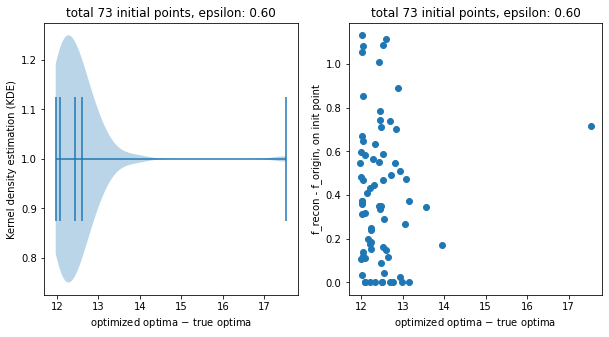

In [5]:

from data_loader import get_recon_landscape, get_recon_pathname


def vis_find_init_pts_by_recon(n_qubits: int, eps: float, noise: str):
    """n=20
    """
    n = n_qubits
    method = 'sv'
    problem = 'maxcut'
    cs_seed = n_qubits
    p = 2

    sf = 0.05
    seed = 0
    if p == 2:
        bs = 12
        gs = 15
    elif p == 1:
        bs = 50
        gs = 100
    else:
        raise ValueError("Invalid depth of QAOA")

    data, data_fname, _ = load_grid_search_data(
        n_qubits=n_qubits, p=p, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed
    )
    origin = data['data']

    recon_path, _, _ = get_recon_pathname(p, problem, method, noise, cs_seed, sf, data_fname)
    # recon1_path = f"figs/recon_p2_landscape/{timestamp}/recon-sf={sf:.3f}-cs_seed={cs_seed}-{miti1_data_fname}"
    recon = get_recon_landscape(p, origin, sf, False, recon_path, cs_seed)

    # recon_path = f"figs/gen_p1_landscape/sv-ideal/2D_CS_recon_p2/sf{sf:.3f}_bs{bs}_gs{gs}_nQ{n_qubits}_seed{seed}_csSeed{cs_seed}.npz"
    # recon = np.load(f"{recon_path}")['recon']

    # ====================== vis ======================
    # eps = 0.6
    if noise == 'ideal' and n == 16:
        init_data = np.load(
            "figs/find_init_pts_by_recon/2022-11-05_22:03:07_OK/recon-eps=0.600-csSeed=16-sv-ideal-n=16-p=2-seed=0-12-15.npz",
            allow_pickle=True)
        C_opt = -17.991035 # 当时忘记存了
        offset = -12
        
    elif noise == 'depolar-0.001-0.02' and n == 16:
        raise NotImplementedError("优化不动")

    elif noise == 'ideal' and n == 20:
        init_data_path = "figs/find_init_pts_by_recon/2022-11-11_14:13:36_OK/init-maxiter=None-eps=0.600-sv-ideal-n=20-p=2-seed=0-12-15.npz"
        print("init data path =", init_data_path)
        init_data = np.load(init_data_path, allow_pickle=True)
        offset = init_data['offset']
        C_opt = init_data['C_opt']
        
    elif noise == 'depolar-0.001-0.02' and n == 20:
        raise NotImplementedError("优化不动")
    
    ids = init_data['ids']
    energies = init_data['min_energies']
    min_recon = init_data['min_recon']
    initial_points = init_data['initial_points']
    recon_init_pt_vals = init_data['recon_init_pt_vals']
    # C_opt = -17.991035
    # offset = -12
    # eps = init_data['eps']

    # print(ids)
    # print(energies)
    energies = np.array(energies, dtype=float)
    # energies += offset
    # print(energies)

    # recon. error on the initial points
    recon_errors = []
    ids_needed = []
    for i in range(len(ids)): # idx: tuples
        # print(recon[idx[0], idx[1], idx[2], idx[3]])
        # print(recon[tuple(idx)])
        # print(idx, recon[idx[0], idx[1], idx[2], idx[3]])
        # continue

        init_recon = recon[tuple(ids[i])]
        init_origin = origin[tuple(ids[i])]
        
        if np.abs(min_recon - init_recon) >= eps:
            continue


        error = init_recon - init_origin
        # error = np.abs(init_recon - init_origin)
        error = np.abs(error)
        # print(init_origin, init_recon, error)
        recon_errors.append(error)
        ids_needed.append(i)

    ids_needed = np.array(ids_needed)
    # print(ids_needed)
    energies = energies[ids_needed]
    print("mean min_energies:", energies.mean())

    ids_higher_bp = [9, 10, 12, 14, 16, 56, 57, 58, 59]
    ids_higher_bp = [9, 10, 12, 14, 16, 53, 56, 57, 58, 59] # stride=8, 结果变好
    ids_higher_bp = [9, 10, 12, 14, 16, 24, 25, 26, 27, 28, 29, 32, 33, 34, 36, 37, 38, 39, 40, 41, 47, 53, 56, 58, 59] # stride=9，结果变坏
    ids_higher_bp = np.array(ids_higher_bp)
    print("mean filtered_energies:", energies[ids_higher_bp].mean())

    # ==================== vis =====================
    import matplotlib.patches as mpatches
    diff = C_opt - energies
    diff = energies - C_opt
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs.reshape(-1)
    # plt.hist(diff, bins=50)
    # https://blog.csdn.net/mighty13/article/details/117405722
    rst = axs[0].violinplot(diff, quantiles=[0.25, 0.5, 0.75], vert=False)

    # color = rst['bodies'][0].get_facecolor().flatten()
    # patch = mpatches.Patch(color=color, label="")
    axs[0].set_xlabel("optimized optima $-$ true optima")
    # axs.set_ylabel("# initial points")
    axs[0].set_ylabel("Kernel density estimation (KDE)")
    # plt.legend()
    axs[0].set_title(f"total {len(ids_needed)} initial points, epsilon: {eps:.2f}")
    print(rst)
    print(rst['cquantiles'])

    # ============ correlation value ==========
    from scipy.stats import pearsonr, spearmanr
    r_p, p_p = pearsonr(diff, recon_errors)
    r_s, p_s = spearmanr(diff, recon_errors)
    print("")
    
    print(f"Pearson : r={r_p:+.5f}\t p={p_p:.5f}\n"
          f"Spearman: r={r_s:+.5f}\t p={p_s:.5f}")
    
    axs[1].scatter(diff, recon_errors)

    # color = rst['bodies'][0].get_facecolor().flatten()
    # patch = mpatches.Patch(color=color, label="")
    axs[1].set_xlabel("optimized optima $-$ true optima")
    # axs.set_ylabel("# initial points")
    axs[1].set_ylabel("f_recon - f_origin, on init point")
    # plt.legend()
    axs[1].set_title(f"total {len(ids_needed)} initial points, epsilon: {eps:.2f}")
    
    # plt.title(f"# qubits={n_qubits}, p={p}")

    # quantiles


vis_find_init_pts_by_recon(n_qubits=16, eps=0.6, noise="ideal")


In [51]:

from data_loader import get_recon_landscape, get_recon_pathname



# old version, for n20 only
def vis_compare_oscar_and_random(n_qubits: int, eps: float, noise: str):
    """n=20
    """
    n = n_qubits
    method = 'sv'
    problem = 'maxcut'
    cs_seed = n_qubits
    p = 2

    sf = 0.05
    seed = 0
    if p == 2:
        bs = 12
        gs = 15
    elif p == 1:
        bs = 50
        gs = 100
    else:
        raise ValueError("Invalid depth of QAOA")

    data, data_fname, _ = load_grid_search_data(
        n_qubits=n_qubits, p=p, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed
    )
    origin = data['data']

    recon_path, _, _ = get_recon_pathname(p, problem, method, noise, cs_seed, sf, data_fname)
    # recon1_path = f"figs/recon_p2_landscape/{timestamp}/recon-sf={sf:.3f}-cs_seed={cs_seed}-{miti1_data_fname}"
    recon = get_recon_landscape(p, origin, sf, False, recon_path, cs_seed)

    # recon_path = f"figs/gen_p1_landscape/sv-ideal/2D_CS_recon_p2/sf{sf:.3f}_bs{bs}_gs{gs}_nQ{n_qubits}_seed{seed}_csSeed{cs_seed}.npz"
    # recon = np.load(f"{recon_path}")['recon']

    # ====================== vis ======================
    # eps = 0.6

    if noise == 'ideal' and n == 20:
        init_data_path = "figs/find_init_pts_by_recon/2022-11-11_14:13:36_OK/init-maxiter=None-eps=0.600-sv-ideal-n=20-p=2-seed=0-12-15.npz"
        print("init data path =", init_data_path)
        # print(init_data_path)
        init_data = np.load(init_data_path, allow_pickle=True)
        init_data = dict(init_data)
        print(init_data.keys())
    elif noise == 'depolar-0.001-0.02' and n == 20:
        raise NotImplementedError("优化不动")
    
    ids = init_data['ids']
    # energies = init_data['min_energies']
    min_recon = init_data['min_recon']
    initial_points = init_data['initial_points']
    recon_init_pt_vals = init_data['recon_init_pt_vals']
    offset = init_data['offset']
    C_opt = init_data['C_opt']
    # eps = init_data['eps']
    # print(f"offset: {offset}, eps: {eps:.3f}")
    assert C_opt == None

    is_old = True
    if is_old:
    
        oscar_energies = init_data['min_energies'], # one to one correspondence to ids
        oscar_energies = oscar_energies[0]
        # oscar_init = init_data['initial_points'], # one to one correspondence to ids
        # oscar_rsts = init_data['oscar_rsts']

        # random_rsts = init_data['random_rsts']
        # random_inits = init_data['random_inits']
        # random_energies = np.array([r[0] for r in random_rsts])
        random_energies = init_data['random_energies']

        print(random_energies)

        print(oscar_energies)

        print(oscar_energies.mean(), random_energies.mean())
    else:
        pass
    # C_opt = -17.991035
    # offset = -12
    # eps = init_data['eps']

    # print(ids)
    # print(energies)
    # energies = np.array(energies, dtype=float)
    # energies += offset
    # es_random = init_data['random_energies']
    # print(energies)

    avg_min_loss_random = np.mean(random_energies)
    avg_min_loss_oscar = np.mean(oscar_energies)

    print("avg_min_loss_random =", avg_min_loss_random)
    print("avg_min_loss_oscar =", avg_min_loss_oscar)

    ids_higher_bp = [12, 13, 15, 16]
    ids_higher_bp = np.array(ids_higher_bp)
    
    print("avg_min_loss_random =", random_energies[ids_higher_bp].mean())
    print("avg_min_loss_oscar =", oscar_energies[ids_higher_bp].mean())


    # # recon. error on the initial points
    is_filter = True
    if is_filter:
        recon_errors = []
        ids_needed = []
        for i in range(len(ids)): # idx: tuples
            # print(recon[idx[0], idx[1], idx[2], idx[3]])
            # print(recon[tuple(idx)])
            # print(idx, recon[idx[0], idx[1], idx[2], idx[3]])
            # continue

            init_recon = recon[tuple(ids[i])]
            init_origin = origin[tuple(ids[i])]
            
            if np.abs(min_recon - init_recon) >= eps:
                continue

            error = init_recon - init_origin
            # error = np.abs(init_recon - init_origin)
            error = np.abs(error)
            # print(init_origin, init_recon, error)
            recon_errors.append(error)
            ids_needed.append(i)

        ids_needed = np.array(ids_needed)
        # print(ids_needed)
        filtered_energies = oscar_energies[ids_needed]
        filtered_mean = np.array(filtered_energies).mean()
        n_filtered = len(ids_needed)
        print(f"epsilon: {eps}, n pts:", n_filtered)

        print(f"OSCAR_mean: {filtered_mean}; RANDOM_mean: {random_energies[:n_filtered].mean()}")

    # # ==================== vis =====================
    # import matplotlib.patches as mpatches
    # diff = C_opt - energies
    # diff = energies - C_opt
    # fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    # axs.reshape(-1)
    # # plt.hist(diff, bins=50)
    # # https://blog.csdn.net/mighty13/article/details/117405722
    # rst = axs[0].violinplot(diff, quantiles=[0.25, 0.5, 0.75], vert=False)

    # # color = rst['bodies'][0].get_facecolor().flatten()
    # # patch = mpatches.Patch(color=color, label="")
    # axs[0].set_xlabel("optimized optima $-$ true optima")
    # # axs.set_ylabel("# initial points")
    # axs[0].set_ylabel("Kernel density estimation (KDE)")
    # # plt.legend()
    # axs[0].set_title(f"total {len(ids_needed)} initial points, epsilon: {eps:.2f}")
    # print(rst)
    # print(rst['cquantiles'])

    # # ============ correlation value ==========
    # from scipy.stats import pearsonr, spearmanr
    # r_p, p_p = pearsonr(diff, recon_errors)
    # r_s, p_s = spearmanr(diff, recon_errors)
    # print("")
    
    # print(f"Pearson : r={r_p:+.5f}\t p={p_p:.5f}\n"
    #       f"Spearman: r={r_s:+.5f}\t p={p_s:.5f}")
    
    # axs[1].scatter(diff, recon_errors)

    # # color = rst['bodies'][0].get_facecolor().flatten()
    # # patch = mpatches.Patch(color=color, label="")
    # axs[1].set_xlabel("optimized optima $-$ true optima")
    # # axs.set_ylabel("# initial points")
    # axs[1].set_ylabel("f_recon - f_origin, on init point")
    # # plt.legend()
    # axs[1].set_title(f"total {len(ids_needed)} initial points, epsilon: {eps:.2f}")
    
    # plt.title(f"# qubits={n_qubits}, p={p}")

    # quantiles
vis_compare_oscar_and_random(n_qubits=20, eps=0.6, noise="ideal")


read grid search data from figs/grid_search/maxcut/sv-ideal-p=2/sv-ideal-n=20-p=2-seed=0-12-15.npz

recon landscape read from figs/grid_search_recon/maxcut/sv-ideal-p=2/recon-cs_seed=20-sf=0.050-sv-ideal-n=20-p=2-seed=0-12-15.npz
init data path = figs/find_init_pts_by_recon/2022-11-11_14:13:36_OK/init-maxiter=None-eps=0.600-sv-ideal-n=20-p=2-seed=0-12-15.npz
dict_keys(['ids', 'initial_points', 'min_energies', 'min_recon', 'recon_init_pt_vals', 'eps', 'C_opt', 'offset', 'maxiter', 'random_energies', 'random_inits'])
[-7.05859375 -6.94042969 -7.10742188 -7.17578125 -7.02929688 -7.20068359
 -7.23974609 -7.14257812 -7.12890625 -7.1640625  -5.31835938 -6.67382813
 -7.15039062 -6.42919922 -6.37207031 -7.25390625 -6.52490234 -6.11279297
 -6.84521484 -6.46923828 -6.80029297 -7.140625   -6.12646484 -7.08837891]
[-7.20654297 -6.23144531 -5.86132812 -6.18212891 -6.60253906 -6.85205078
 -6.52099609 -7.15234375 -7.10791016 -6.71582031 -7.12207031 -6.51757813
 -6.52539062 -5.45947266 -6.06298828 -6


read grid search data from figs/grid_search/maxcut/sv-ideal-p=2/sv-ideal-n=20-p=2-seed=0-12-15.npz

recon landscape read from figs/grid_search_recon/maxcut/sv-ideal-p=2/recon-cs_seed=20-sf=0.050-sv-ideal-n=20-p=2-seed=0-12-15.npz
init data path = figs/find_init_pts_by_recon/2022-11-11_14:13:36_OK/init-maxiter=None-eps=0.600-sv-ideal-n=20-p=2-seed=0-12-15.npz
dict_keys(['ids', 'initial_points', 'min_energies', 'min_recon', 'recon_init_pt_vals', 'eps', 'C_opt', 'offset', 'maxiter', 'random_energies', 'random_inits'])
[-7.05859375 -6.94042969 -7.10742188 -7.17578125 -7.02929688 -7.20068359
 -7.23974609 -7.14257812 -7.12890625 -7.1640625  -5.31835938 -6.67382813
 -7.15039062 -6.42919922 -6.37207031 -7.25390625 -6.52490234 -6.11279297
 -6.84521484 -6.46923828 -6.80029297 -7.140625   -6.12646484 -7.08837891]
[-7.20654297 -6.23144531 -5.86132812 -6.18212891 -6.60253906 -6.85205078
 -6.52099609 -7.15234375 -7.10791016 -6.71582031 -7.12207031 -6.51757813
 -6.52539062 -5.45947266 -6.06298828 -6

IndexError: invalid index to scalar variable.

In [38]:
# use only once
def merge_n20_data():
    # random
    d1 = np.load(
        "figs/find_init_pts_by_recon/2022-11-11_13:57:36_random/init-maxiter=None-eps=0.600-sv-ideal-n=20-p=2-seed=0-12-15.npz"
        , allow_pickle=True
    )

    # oscar
    d2 = np.load(
        "figs/find_init_pts_by_recon/2022-11-11_00:29:27_oscar/init-maxiter=None-eps=0.600-sv-ideal-n=20-p=2-seed=0-12-15.npz"
        , allow_pickle=True
    )

    d1 = dict(d1)
    print(d1)
    d2 = dict(d2)
    print(d2)

    print("d1 =", d1.keys())
    print("d2 =", d2.keys())
    
    # print(d1['C_opt'])
    # print(d1['offset'])
    # print(d2['min_energies'])
    
    d1['random_energies'] = d2['random_energies']
    d1['random_inits'] = d2['random_inits']
    d1['maxiter'] = d2['maxiter']

    print(d1.keys())

    # print(d1)
    # d1 = d2

    save_path = "figs/find_init_pts_by_recon/2022-11-11_14:13:36_OK/init-maxiter=None-eps=0.600-sv-ideal-n=20-p=2-seed=0-12-15.npz"
    np.savez_compressed(
        save_path,
        ids=d1['ids'],
        initial_points=d1['initial_points'], # one to one correspondence to ids
        min_energies=d1['min_energies'], # one to one correspondence to ids
        min_recon=d1['min_recon'],
        recon_init_pt_vals=d1['recon_init_pt_vals'],
        eps=d1['eps'],
        C_opt=d1['C_opt'],
        offset=d1['offset'],
        maxiter=d1['maxiter'],

        # diff
        random_energies=d1['random_energies'],
        random_inits=d1['random_inits'],
    )

    d = np.load(
        save_path,
        allow_pickle=True
    )
    d = dict(d)
    print(d.keys())
    

merge_n20_data()

{'ids': array([[ 0,  5, 13,  5],
       [ 0,  5, 14,  6],
       [ 0,  6, 13,  4],
       [ 1,  2,  9, 12],
       [ 1,  3, 10, 10],
       [ 1,  3, 10, 11],
       [ 1,  3, 11, 12],
       [ 1,  3, 12, 11],
       [ 1,  4, 11, 11],
       [ 1,  4, 12, 11],
       [ 1,  4, 12, 12],
       [ 1,  4, 13, 12],
       [ 1,  8, 10,  1],
       [ 2,  2, 11, 11],
       [ 3,  1, 10,  9],
       [ 8,  9,  3,  3],
       [ 9,  9,  3,  4],
       [10,  8,  3,  3],
       [10,  8,  4,  2],
       [11,  5,  2,  9],
       [11,  6,  1, 11],
       [11,  6,  1, 12],
       [11,  8,  2,  3],
       [11,  9,  3,  0]]), 'initial_points': array([[ 0.67319843, -0.39269908, -0.22439948,  0.14279967],
       [ 0.78539816, -0.39269908, -0.11219974,  0.14279967],
       [ 0.67319843, -0.39269908, -0.33659921,  0.24989942],
       [ 0.22439948, -0.28559933,  0.56099869, -0.17849958],
       [ 0.33659921, -0.28559933,  0.33659921, -0.07139983],
       [ 0.33659921, -0.28559933,  0.44879895, -0.07139983],
      

In [37]:
def merge_diff_eps_data():
    paths = [
        "figs/find_init_pts_by_recon/2022-11-15_02:57:13/init-maxiter=None-eps=[0.4]-sv-ideal-n=16-p=2-seed=0-12-15.npz"
        ,
        "figs/find_init_pts_by_recon/2022-11-15_02:48:16/init-maxiter=None-eps=[0.4, 0.45]-sv-ideal-n=16-p=2-seed=0-12-15.npz"
        ,
        "figs/find_init_pts_by_recon/2022-11-15_03:07:24/init-maxiter=None-eps=[0.45, 0.5]-sv-ideal-n=16-p=2-seed=0-12-15.npz"
    ]

    init_datas = []
    for path in paths:
        init_datas.append(np.load(path, allow_pickle=True))

    oscar_energies = []
    oscar_inits = []
    random_energies = []
    for data in init_datas:
        oscar_energies.append(data['oscar_energies'])
        # min_energies,
        # oscar_inits=ids, # indices

        # random initialization method
        # random_energies=random_energies,
        # random_rsts=random_rsts,
        random_rsts = data['random_rsts']
        random_energies.append(
            np.array([r[0] for r in random_rsts])
        )
    
    oscar_energies = np.concatenate(oscar_energies)
    random_energies = np.concatenate(random_energies)

    print(oscar_energies.shape)
    print(random_energies.shape)

    print(oscar_energies.mean(), random_energies.mean())
    print(oscar_energies.min(), random_energies.min())
    return
merge_diff_eps_data()

(39,)
(39,)
-5.504181690705129 -5.3990009014423075
-6.01904296875 -6.01318359375
